In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = SAGEConv(in_channels, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, out_channels)
        self.norm1 = torch.nn.LayerNorm(128)
        self.norm2 = torch.nn.LayerNorm(64)
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.dropout(x)
        x = F.selu(self.conv1(x, edge_index))
        x = self.norm1(x)
        x = self.dropout(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

class GATDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATDecoder, self).__init__()
        self.conv1 = SAGEConv(in_channels, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, out_channels)
        self.norm1 = torch.nn.LayerNorm(64)
        self.norm2 = torch.nn.LayerNorm(out_channels)
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, x, edge_index):
        x = self.dropout(x)
        x = F.selu(self.conv1(x, edge_index))
        x = self.norm1(x)
        x = self.dropout(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

class GATAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GATAutoencoder, self).__init__()
        self.encoder = GATEncoder(in_channels, hidden_channels)
        self.decoder = GATDecoder(hidden_channels, in_channels)

    def forward(self, data):
        z = self.encoder(data)
        x_hat = self.decoder(z, data.edge_index)
        return x_hat, z


In [4]:
with open("/kaggle/input/graph-torch-geometric/graphs.picke", "rb") as f:
    gs = pickle.load(f)
gs[0]

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Data(x=[3, 1, 128], edge_index=[2, 3])

In [5]:
# Normalize embeddings to the range [0, 1]
def normalize_embeddings(data):
    min_val = data.min(dim=0, keepdim=True)[0]
    max_val = data.max(dim=0, keepdim=True)[0]
    data = (data - min_val) / (1 + max_val - min_val)
    return data

In [6]:
def convert_graph_datatype(g):
    x = torch.reshape(g.x, (g.x.shape[0], 128))
#     x = normalize_embeddings(x)
    return Data(x=x.type(torch.float), edge_index=g.edge_index).to("cuda")

converted_graph = [convert_graph_datatype(g) for g in gs]

In [7]:
# Define DataLoader
batch_size = 1
num_features = 128
loader = DataLoader(converted_graph, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
# Model instantiation
model = GATAutoencoder(num_features, hidden_channels=8).to("cuda")
# model = GATAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

In [9]:
# Training loop
def train():
    model.train()
    losses = []
    for data in loader:
        optimizer.zero_grad()
        x_hat, z = model(data)
        loss = criterion(x_hat, data.x)  # Reconstruction loss
        losses.append(loss.to("cpu").detach().numpy())
        loss.backward()
        optimizer.step()
    return np.mean(losses)

In [10]:
# Run training
losses = []
for epoch in range(1000):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}')

Epoch 1, Training Loss: 172848768.0000
Epoch 101, Training Loss: 55547768.0000
Epoch 201, Training Loss: 49550436.0000
Epoch 301, Training Loss: 46634812.0000
Epoch 401, Training Loss: 45181736.0000
Epoch 501, Training Loss: 44313844.0000
Epoch 601, Training Loss: 43919212.0000
Epoch 701, Training Loss: 43161760.0000
Epoch 801, Training Loss: 42757788.0000
Epoch 901, Training Loss: 42702140.0000


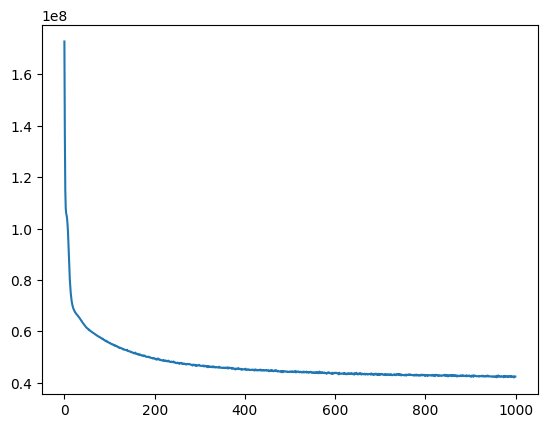

In [11]:
plt.plot(losses)

In [12]:
threshold = np.mean(losses) + 3*np.std(losses)
threshold

75264740.0

In [13]:
# Inference for anomaly detection
def detect_anomalies(data, threshold=0.1):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader):
#             print(i)
            x_hat, z = model(data)
            reconstruction_error = torch.mean((x_hat - data.x) ** 2, dim=1)
            anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error, data.x, x_hat

In [14]:
# Detect anomalies in the dataset
anomalies, reconstruction_error, x, x_hat = detect_anomalies(data = loader, threshold = threshold)
print(f"Anomalies detected: {anomalies.sum().item()}")

Anomalies detected: 3


In [15]:
torch.save(model, "ae_sage_model_selu.pth")

In [16]:
ccc = torch.load("ae_sage_model_selu.pth")
ccc.eval()

/tmp/ipykernel_24/3817213920.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ccc = torch.load("ae_sage_model_selu.pth")


GATAutoencoder(
  (encoder): GATEncoder(
    (conv1): SAGEConv(128, 128, aggr=mean)
    (conv2): SAGEConv(128, 64, aggr=mean)
    (conv3): SAGEConv(64, 8, aggr=mean)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): GATDecoder(
    (conv1): SAGEConv(8, 64, aggr=mean)
    (conv2): SAGEConv(64, 128, aggr=mean)
    (conv3): SAGEConv(128, 128, aggr=mean)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)